## Exploratory Data Analysis <a id='1_Exploratory_Data_Analysis'></a>

### 1.1 Table of Contents <a id='1.1_Table_of_Contents'></a>
* [1 Exploratory Data Analysis - West Nile Virus](#1_Exploratory_Data_Analysis)
     * [1.1 Table of Contents](#1.1_Table_of_Contents)
     * [1.2 Imports & Loads](#1.2_Imports)
     * [1.3 Train Data](#1.3_Train_Data)
         * [1.3.1 Distance Split](#1.3.1_Distance_Split)

### 1.2 Imports & Loads <a id='1.2_Imports'></a>

In [1]:
# Import from Data Wrangling Notebook
%store -r station
%store -r spray
%store -r train

In [2]:
# Packages
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import geopy.distance
import numpy as np
from sklearn.preprocessing import OneHotEncoder
import shap

### 1.3 Trap Exploring <a id='1.3_Train_Data'></a>

#### 1.3.1 Time <a id='1.3.1_Distance_Split'></a>

Using the barplot function without specifying `order` is likely to produce an incorrect plot.


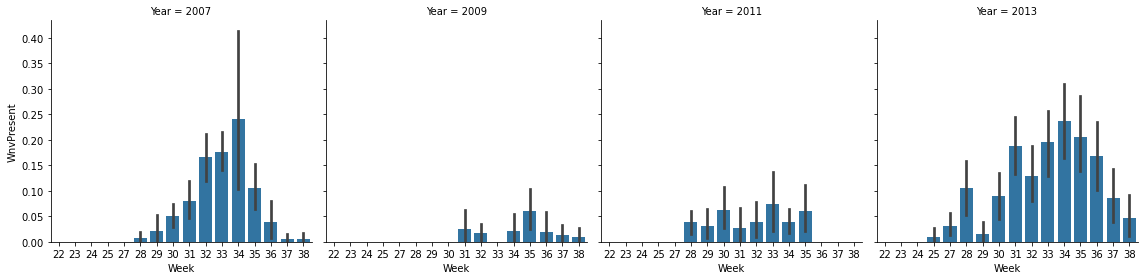

In [3]:
g = sns.FacetGrid(train, col="Year", height=4)
g.map(sns.barplot, "Week", "WnvPresent")

Clearly some peaks around week 34 in 2007 and 2013, while 2009 and 2011 are more subdued. More to investigate here.

In [4]:
species = train[['Species', 'NumMosquitos', 'WnvPresent']].groupby(by='Species').sum().reset_index()
print(species)

                  Species  NumMosquitos  WnvPresent
0         CULEX ERRATICUS             7           0
1           CULEX PIPIENS         44671         184
2  CULEX PIPIENS/RESTUANS         66268         225
3          CULEX RESTUANS         23431          48
4        CULEX SALINARIUS           145           0
5          CULEX TARSALIS             7           0
6         CULEX TERRITANS           510           0


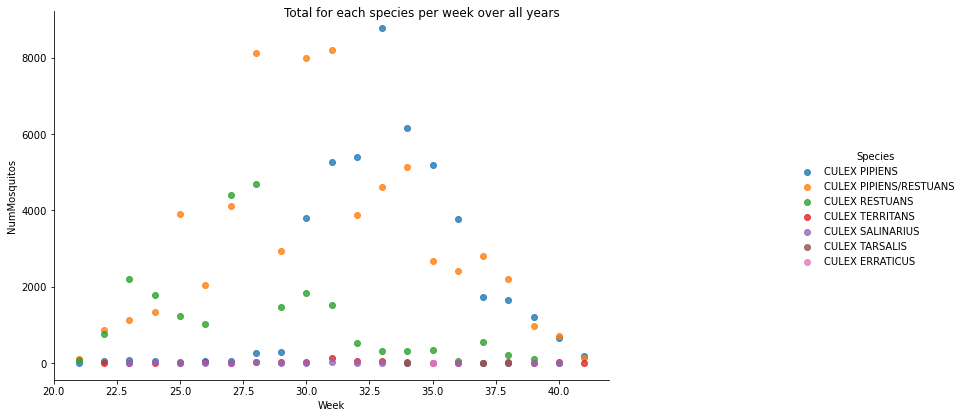

In [5]:
# total mosquitos in a given week from all years.
df_temp = train.groupby(['Week','Species'], as_index=False).sum().reindex()

fg = sns.lmplot(data=df_temp, x = 'Week', y='NumMosquitos', hue='Species', fit_reg=False);
fg.fig.set_figheight(6)
fg.fig.set_figwidth(15)
fg.fig.suptitle("Total for each species per week over all years");

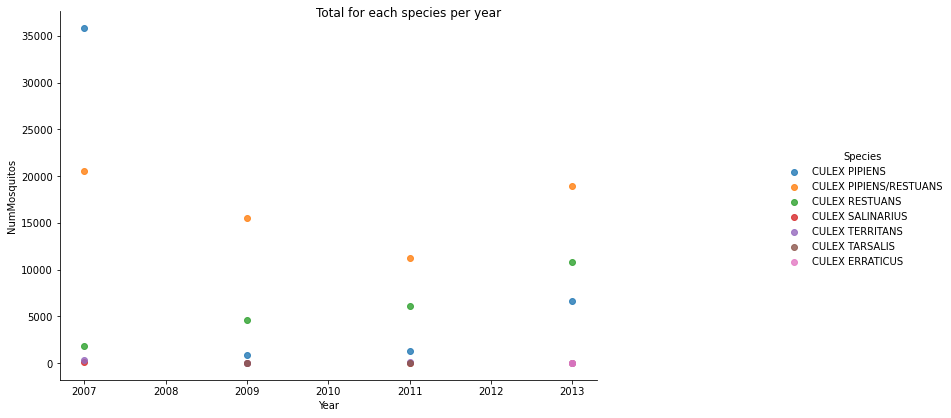

In [6]:
# total mosquitos in a given year
df_temp = train.groupby(['Year','Species'], as_index=False).sum().reindex()

fg = sns.lmplot(data=df_temp, x='Year', y='NumMosquitos', hue='Species', fit_reg=False);
fg.fig.set_figheight(6)
fg.fig.set_figwidth(15)
fg.fig.suptitle("Total for each species per year");

Interesting, we can see a clear u shape for both pip/res and pip species and a slow growth of res. Hypothesis: the res type can survive in a wider range of conditions so is active for longer, but pip is overall best suited for propagating in the local environment and is more prone to carrying WNV

In [7]:
# looking more closely at just the infected species
train_temp = train.loc[train['Species'].isin(['CULEX PIPIENS', 'CULEX PIPIENS/RESTUANS', 'CULEX RESTUANS'])]

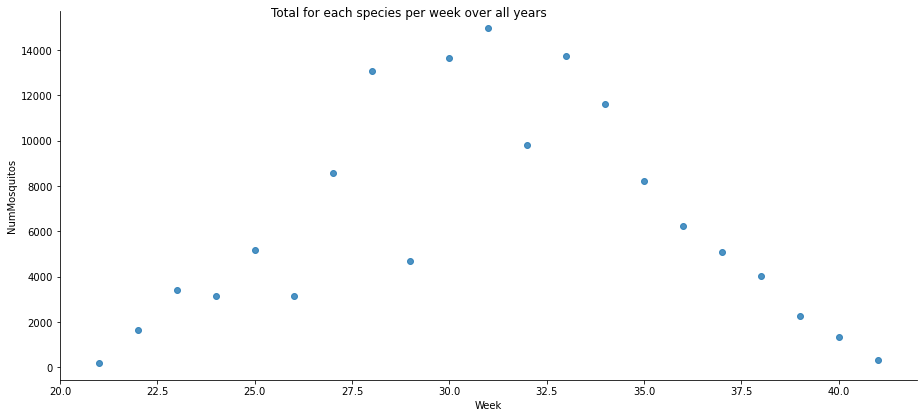

In [8]:
# total mosquitos in a given week from all years, really just another way of looking at our first chart but only with wnv ones
df_temp = train_temp.groupby(['Week'], as_index=False).sum().reindex()

fg = sns.lmplot(data=df_temp, x = 'Week', y='NumMosquitos', fit_reg=False);
fg.fig.set_figheight(6)
fg.fig.set_figwidth(15)
fg.fig.suptitle("Total for each species per week over all years");

Text(0, 0.5, '')

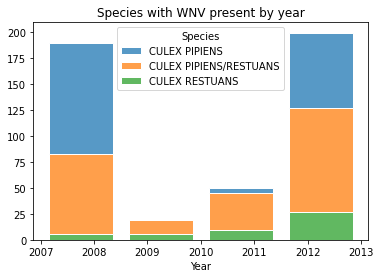

In [9]:
df_temp = train_temp.groupby(['Year', 'Species'])['WnvPresent'].sum().unstack().fillna(0)

ax = sns.histplot(
    train_temp,
    x='Year',
    weights='WnvPresent',
    hue='Species',
    multiple='stack',
    edgecolor='white',
    shrink=0.8,
    bins=4
)

ax.set_title('Species with WNV present by year')
ax.set_ylabel(None)

In [10]:
Week_count = train.Week.value_counts()
Week_wnv=train.groupby('Week')['WnvPresent'].sum().sort_values(ascending=False)
Week_count=Week_count.to_frame().join(Week_wnv.to_frame())
Week_count = Week_count.rename(columns={'Week': 'Sample', 'WnvPresent': 'Wnv_sample'})
Week_count['Wnv_percent']=Week_count.Wnv_sample*100/Week_count.Sample
Week_count.reset_index(inplace=True)
Week_count=Week_count.rename(columns={'index': 'Week'})
Week_count.set_index(["Week"], inplace = True)
Week_count.sort_values(by='Wnv_percent',ascending=False)

,Sample,Wnv_sample,Wnv_percent
Week,,,
34,747,111,14.859438
33,514,75,14.591440
35,297,40,13.468013
36,289,38,13.148789
32,552,44,7.971014
31,753,52,6.905710
30,682,29,4.252199
37,685,26,3.795620
38,482,12,2.489627


Weeks 21 to 24 have never had WNV as well as week 41, we can cut thoseto reduce the count of non-wnv samples

### 1.4 Weather Exploring <a id='1.4_Weather'></a>

#### 1.4.1 Tempature

In [11]:
temp_col = ['AvgSpeed', 'Cool', 'Heat', 'PrecipTotal', 'ResultDir',
       'ResultSpeed', 'SeaLevel', 'StnPressure', 'Sunrise',
       'Sunset', 'WetBulb', 'low_vis', 'rain', 'TmaxC', 'TminC', 'TavgC',
       'DewPointC', 'RHmax', 'RHmin', 'RHavg', 'Week', 'Year']
narrow_station = station[temp_col]

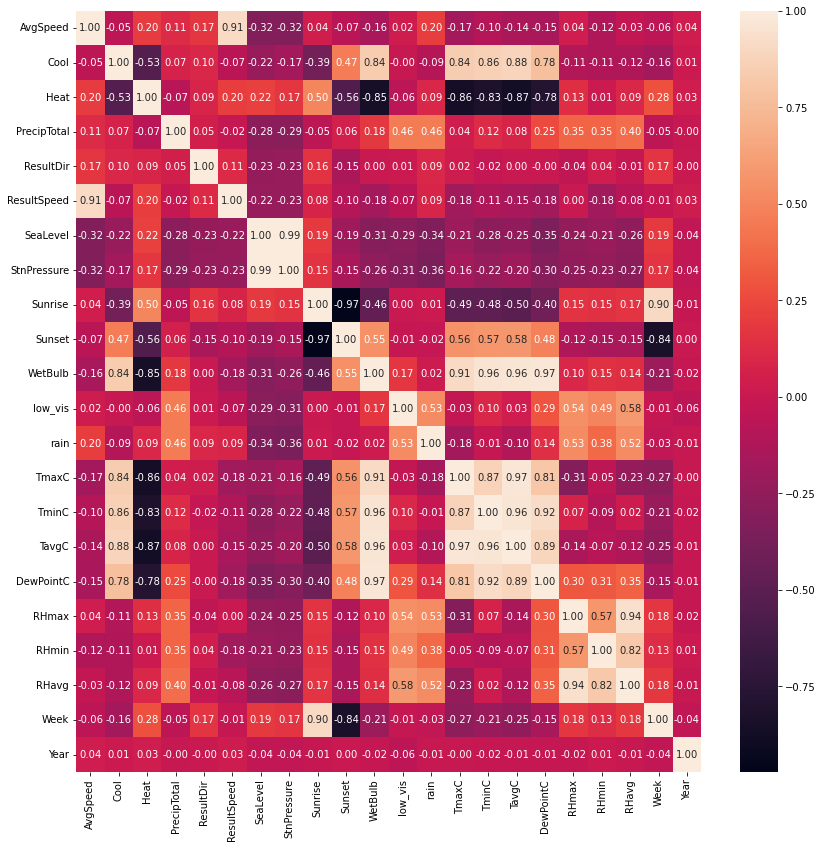

In [12]:
plt.subplots(figsize=(14,14))

corr = narrow_station.corr(method='pearson')

ax = sns.heatmap(corr, annot=True,annot_kws={'size':10}, fmt=".2f")
plt.savefig('heatmap.png',dpi=600)

There's a strong correllation between tempatures as to be expected, but also with the DewPoint, which is also expected. As well as the Relative Humidity Min/Max/Avg among itself. Cool and Heat respectively correlated and negatively correlated with T. Sunset and Sunrise has correlations with the week of the year, and StnPressure has correlations with sea level. Heatbulb has a negative correlation with heat. Nothing suprising.

### Feature Selection

In [13]:
station.columns

Index(['AvgSpeed', 'Cool', 'Heat', 'PrecipTotal', 'ResultDir', 'ResultSpeed',
       'SeaLevel', 'StnPressure', 'Sunrise', 'Sunset', 'WetBulb', 'low_vis',
       'rain', 'TmaxC', 'TminC', 'TavgC', 'DewPointC', 'RHmax', 'RHmin',
       'RHavg', 'AvgSpeed_d7', 'Cool_d7', 'DewPoint_d7', 'Heat_d7',
       'PrecipTotal_d7', 'ResultDir_d7', 'ResultSpeed_d7', 'SeaLevel_d7',
       'StnPressure_d7', 'Sunrise_d7', 'Sunset_d7', 'WetBulb_d7', 'low_vis_d7',
       'rain_d7', 'TmaxC_d7', 'TminC_d7', 'TavgC_d7', 'DewPointC_d7',
       'RHmax_d7', 'RHmin_d7', 'RHavg_d7', 'AvgSpeed_d14', 'Cool_d14',
       'DewPoint_d14', 'Heat_d14', 'PrecipTotal_d14', 'ResultDir_d14',
       'ResultSpeed_d14', 'SeaLevel_d14', 'StnPressure_d14', 'Sunrise_d14',
       'Sunset_d14', 'WetBulb_d14', 'low_vis_d14', 'rain_d14', 'TmaxC_d14',
       'TminC_d14', 'TavgC_d14', 'DewPointC_d14', 'RHmax_d14', 'RHmin_d14',
       'RHavg_d14', 'Week', 'Year'],
      dtype='object')

In [14]:
# Drop weather features exhibiting highly corrleated features retaining only one of them

# AvgSpeed will be kept in place of ResultSpeed
# TavgC will be kept in place of all T's
# StnPressure but not sealevel
# RHmax and RHmin, becuase they don't correlate with each other but do with avg
# Dewpoint and Wetbulb will drop becuase they correlate with the above TavgC
temp_cols = ['ResultSpeed', 'ResultSpeed_d7', 'ResultSpeed_d14','TmaxC' ,'TmaxC_d7' ,'TmaxC_d14' ,'TminC' ,'TminC_d7' ,
             'TminC_d14' ,'SeaLevel' ,'SeaLevel_d7' ,'SeaLevel_d14' ,'Sunrise' ,'Sunrise_d7' ,'Sunrise_d14' ,'Sunset' ,
             'Sunset_d7' ,'Sunset_d14' ,'RHavg' ,'RHavg_d7' ,'RHavg_d14' ,'WetBulb' ,'WetBulb_d7' ,'WetBulb_d14' ,'DewPointC' ,
             'DewPointC_d7' ,'DewPointC_d14']

station = station.drop(columns=temp_cols, axis = 1)

station.shape

(1458, 37)

In [15]:
# Before we remove a few other columns some pre-removal for other stuff
# Remove weeks where no virus was observed And not between weeks where virus was ever observed
train = train[train['Week'].values < 41]
train = train[train['Week'].values > 24]
train.Week.unique()

array([26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 25],
      dtype=int64)

In [16]:
# Need to merge before removing time based cols
trainstation = pd.merge(train, station,  how='left', left_on=['Year','Week'], right_on = ['Year','Week'])

In [17]:
#One hotencoding for species and week

trainstation = pd.get_dummies(trainstation, columns=['Species','Week'])

In [18]:
# drop mosquito species without virus
species_no_wnv=['Species_CULEX TERRITANS','Species_CULEX SALINARIUS', 'Species_CULEX TARSALIS','Species_CULEX ERRATICUS' ]
trainstation=trainstation.drop(columns=species_no_wnv)
trainstation.columns

Index(['Date', 'Year', 'Trap', 'Latitude', 'Longitude', 'NumMosquitos',
       'WnvPresent', 'AvgSpeed', 'Cool', 'Heat', 'PrecipTotal', 'ResultDir',
       'StnPressure', 'low_vis', 'rain', 'TavgC', 'RHmax', 'RHmin',
       'AvgSpeed_d7', 'Cool_d7', 'DewPoint_d7', 'Heat_d7', 'PrecipTotal_d7',
       'ResultDir_d7', 'StnPressure_d7', 'low_vis_d7', 'rain_d7', 'TavgC_d7',
       'RHmax_d7', 'RHmin_d7', 'AvgSpeed_d14', 'Cool_d14', 'DewPoint_d14',
       'Heat_d14', 'PrecipTotal_d14', 'ResultDir_d14', 'StnPressure_d14',
       'low_vis_d14', 'rain_d14', 'TavgC_d14', 'RHmax_d14', 'RHmin_d14',
       'Species_CULEX PIPIENS', 'Species_CULEX PIPIENS/RESTUANS',
       'Species_CULEX RESTUANS', 'Week_25', 'Week_26', 'Week_27', 'Week_28',
       'Week_29', 'Week_30', 'Week_31', 'Week_32', 'Week_33', 'Week_34',
       'Week_35', 'Week_36', 'Week_37', 'Week_38', 'Week_39', 'Week_40'],
      dtype='object')

In [21]:
# Drop time and object type cols
dropcols=['Date','Year', 'Trap']
trainstation=trainstation.drop(columns=dropcols)

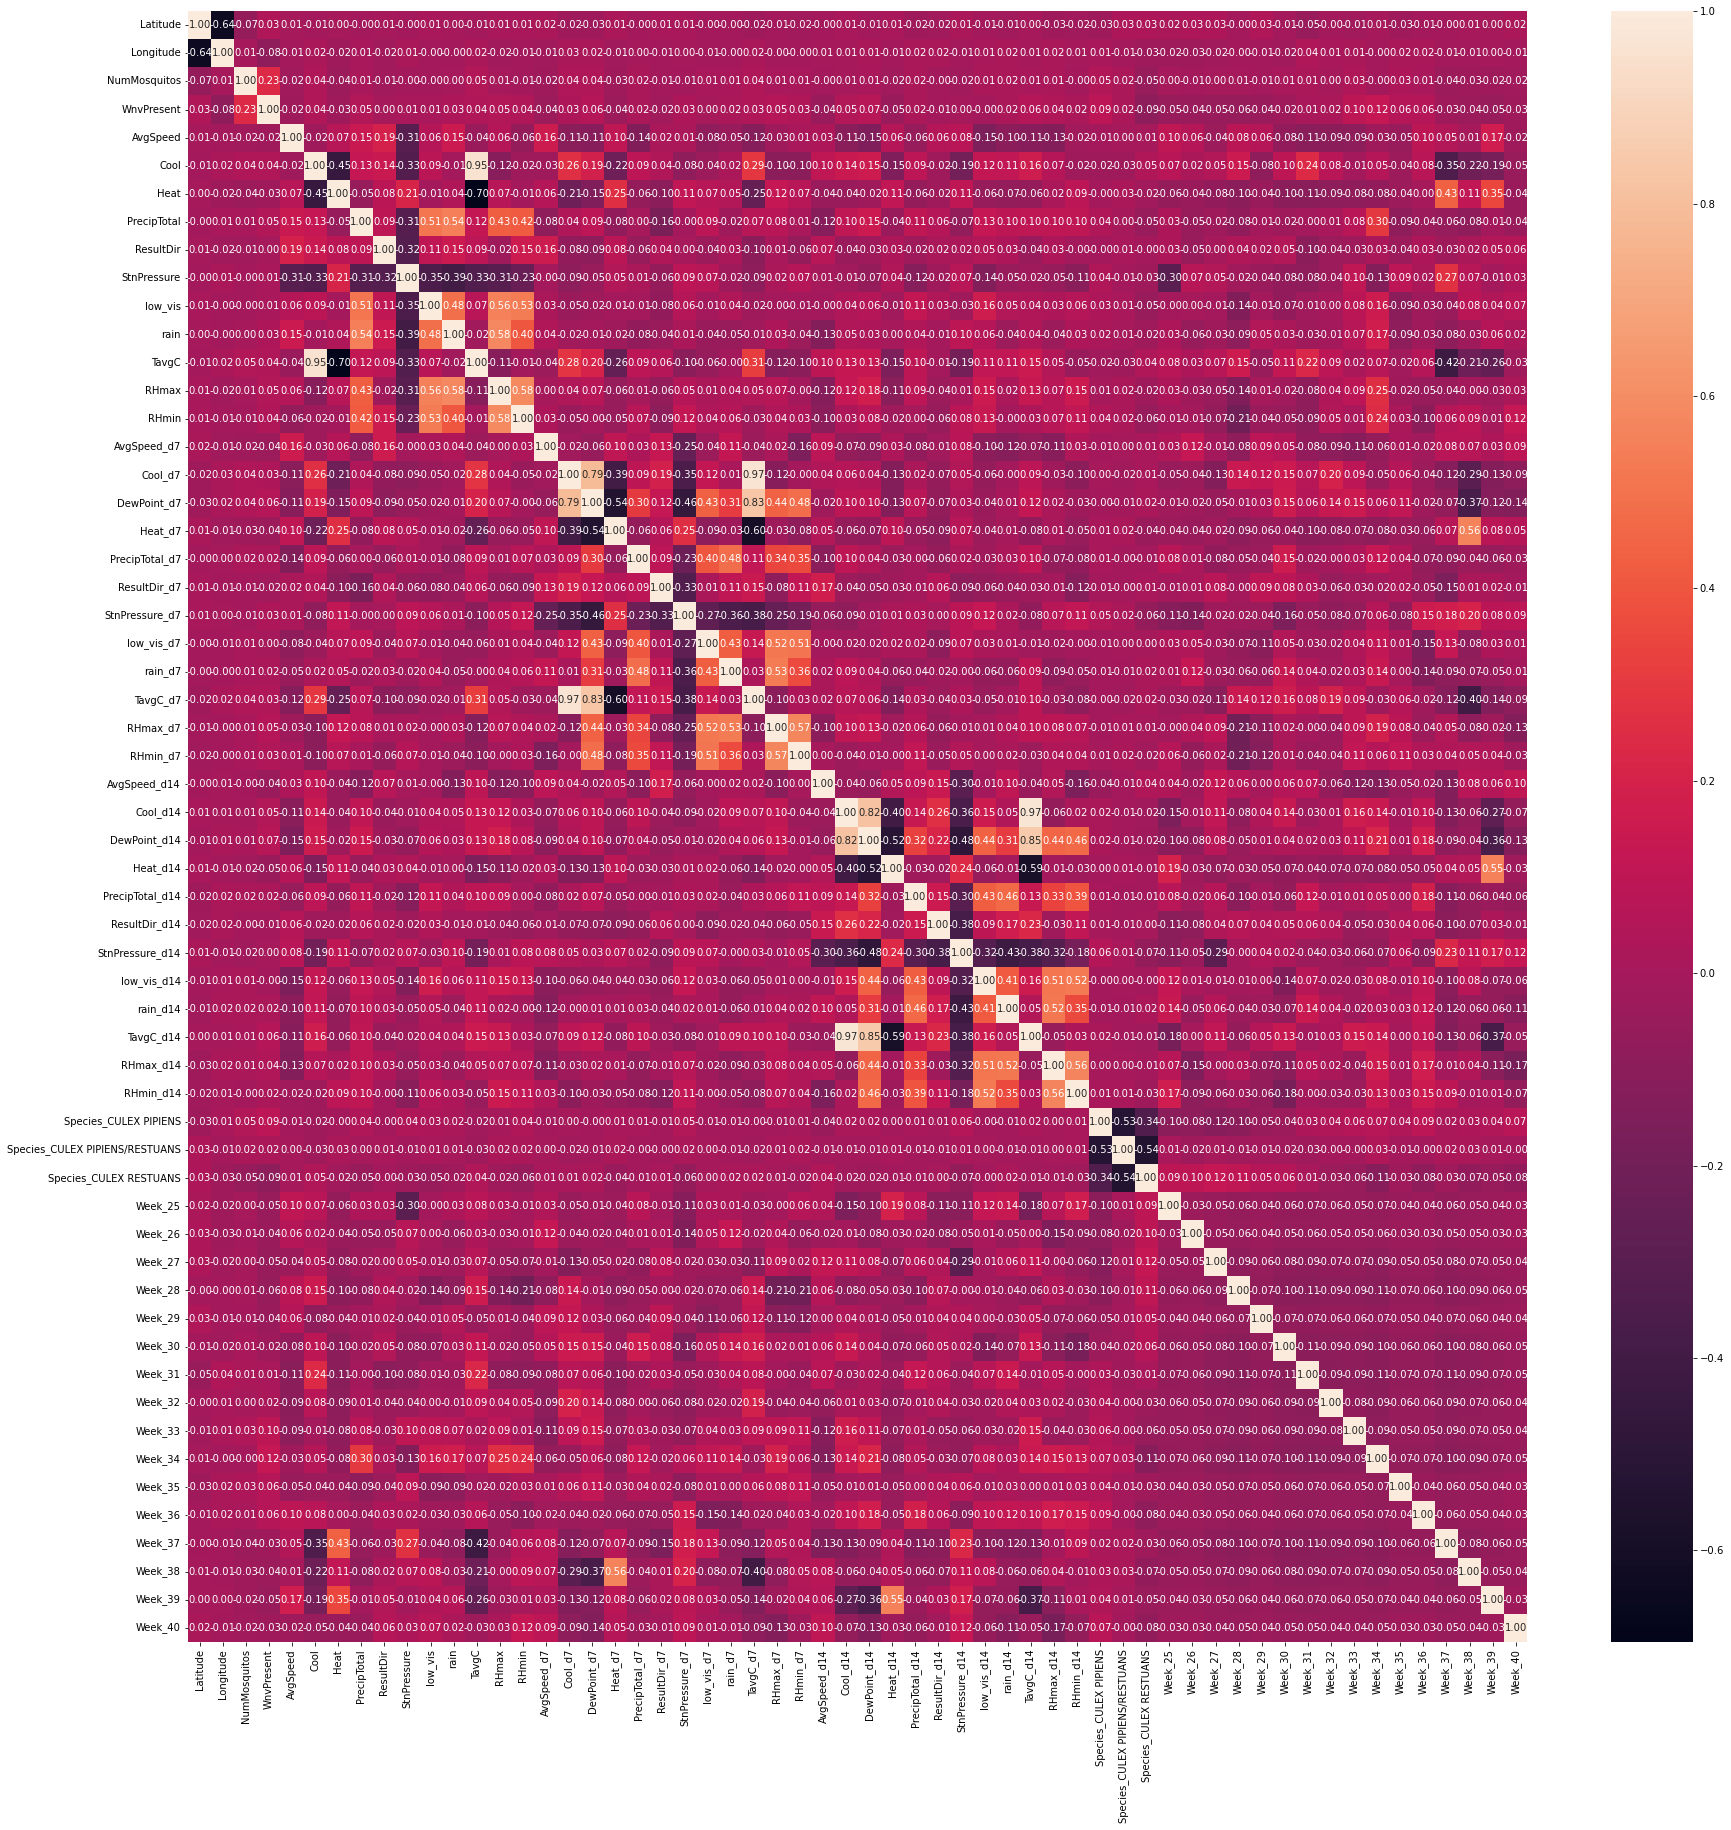

In [22]:
# Last correlation will probably look ugly
plt.subplots(figsize=(30,30))

corr = trainstation.corr(method='pearson')
ax = sns.heatmap(corr, annot=True,annot_kws={'size':10}, fmt=".2f")

In [23]:
%store trainstation

Stored 'trainstation' (DataFrame)
